### 0. Import Library and Upload Files

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from yellowbrick.cluster import KElbowVisualizer

from google.colab import drive, files
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import layers, Model

In [ ]:
files.upload()
dfraw = pd.read_csv('predictive_maintenance.csv')
df = dfraw.drop(['UDI', 'Product ID'], axis=1)
print(df.head())

Saving predictive_maintenance.csv to predictive_maintenance (1).csv
  Type  Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0    M                298.1                    308.6                    1551   
1    L                298.2                    308.7                    1408   
2    L                298.1                    308.5                    1498   
3    L                298.2                    308.6                    1433   
4    L                298.2                    308.7                    1408   

   Torque [Nm]  Tool wear [min]  Target Failure Type  
0         42.8                0       0   No Failure  
1         46.3                3       0   No Failure  
2         49.4                5       0   No Failure  
3         39.5                7       0   No Failure  
4         40.0                9       0   No Failure  


# 1 Praproses Data

In [ ]:
df.describe()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900
std,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981
min,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000
25%,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000
50%,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000
75%,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000
max,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000


In [ ]:
# Mengecek dataset menggunakan isnull().sum()
df.isnull().sum()

,0
Type,0
Air temperature [K],0
Process temperature [K],0
Rotational speed [rpm],0
Torque [Nm],0
Tool wear [min],0
Target,0
Failure Type,0


In [ ]:
# Mengecek dataset menggunakan duplicated().sum()
df.duplicated().sum()

np.int64(0)

In [ ]:
le = LabelEncoder()
yc = le.fit_transform(df['Failure Type'])

In [ ]:
cat = df.select_dtypes(include=['object']).columns.tolist()
for col in cat:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1.0,0.304348,0.358025,0.222934,0.535714,0.000000,0.0,0.2
1,0.5,0.315217,0.370370,0.139697,0.583791,0.011858,0.0,0.2
2,0.5,0.304348,0.345679,0.192084,0.626374,0.019763,0.0,0.2
3,0.5,0.315217,0.358025,0.154249,0.490385,0.027668,0.0,0.2
4,0.5,0.315217,0.370370,0.139697,0.497253,0.035573,0.0,0.2


In [ ]:

mm = MinMaxScaler(feature_range=(0, 1))
num = df.select_dtypes(include=['int64', 'float64']).columns
df[num] = mm.fit_transform(df[num])
df.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1.0,0.304348,0.358025,0.222934,0.535714,0.000000,0.0,0.2
1,0.5,0.315217,0.370370,0.139697,0.583791,0.011858,0.0,0.2
2,0.5,0.304348,0.345679,0.192084,0.626374,0.019763,0.0,0.2
3,0.5,0.315217,0.358025,0.154249,0.490385,0.027668,0.0,0.2
4,0.5,0.315217,0.370370,0.139697,0.497253,0.035573,0.0,0.2


In [ ]:
df.columns.tolist()

['Type',
 'Air temperature [K]',
 'Process temperature [K]',
 'Rotational speed [rpm]',
 'Torque [Nm]',
 'Tool wear [min]',
 'Target',
 'Failure Type']

In [ ]:
X = df.drop(['Target', 'Failure Type'], axis=1)

Y = df[['Target', 'Failure Type']]

X_train, X_test, Y_train, Y_test = train_test_split(
    X,
    Y,
    test_size=0.3,
    random_state=42
)

# Pisahkan kembali
yb_train = Y_train['Target']
yc_train = Y_train['Failure Type']

yb_test = Y_test['Target']
yc_test = Y_test['Failure Type']


In [ ]:
inputs = layers.Input(shape=(X_train.shape[1],))

# shared layers
x = layers.Dense(64, activation='relu')(inputs)
x = layers.Dense(32, activation='relu')(x)

# output 1: binary
out_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(x)

# output 2: multiclass
num_classes = len(le.classes_)
out_multi = layers.Dense(num_classes, activation='softmax', name='multiclass_output')(x)

# model
model = Model(inputs, [out_binary, out_multi])

model.compile(
    optimizer='adam',
    loss={
        'binary_output': 'binary_crossentropy',
        'multiclass_output': 'sparse_categorical_crossentropy'
    },
    metrics={
        'binary_output': 'accuracy',
        'multiclass_output': 'accuracy'
    }
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 6)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │        448 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │      2,080 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ binary_output       │ (None, 1)         │         33 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiclass_output   │ (None, 6)         │        198 │ dense_3[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,759 (10.78 KB)

 Trainable params: 2,759 (10.78 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train,
    {
        'binary_output': yb_train,
        'multiclass_output': yc_train
    },
    validation_split=0.2,
    epochs=20,
    batch_size=32
)

Epoch 1/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_output_accuracy: 0.9631 - binary_output_loss: 0.3529 - loss: 0.9723 - multiclass_output_accuracy: 0.0146 - multiclass_output_loss: 0.6194 - val_binary_output_accuracy: 0.9600 - val_binary_output_loss: 0.1844 - val_loss: 0.2287 - val_multiclass_output_accuracy: 0.0129 - val_multiclass_output_loss: 0.0443
Epoch 2/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_output_accuracy: 0.9665 - binary_output_loss: 0.1592 - loss: 0.1999 - multiclass_output_accuracy: 0.0117 - multiclass_output_loss: 0.0407 - val_binary_output_accuracy: 0.9600 - val_binary_output_loss: 0.1767 - val_loss: 0.2151 - val_multiclass_output_accuracy: 0.0129 - val_multiclass_output_loss: 0.0382
Epoch 3/20
175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_output_accuracy: 0.9682 - binary_output_loss: 0.1440 - loss: 0.1763 - multiclass_output_accuracy: 0.0120 - multiclass_output_loss: 0.0322 - val_binary_output_accuracy: 0.9600 - val_binary_output_loss: 0.1660

In [ ]:
yb_pred, yc_pred = model.predict(X_test)
yb_pred = (yb_pred > 0.5).astype(int)
yc_pred = np.argmax(yc_pred, axis=1)

yb_test = yb_test.astype(int)
yc_test = yc_test.astype(int)

model.evaluate(
    X_test,
    {
        'binary_output': yb_test,
        'multiclass_output': yc_test
    }
)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - binary_output_accuracy: 0.9706 - binary_output_loss: 0.0875 - loss: 0.1166 - multiclass_output_accuracy: 0.9934 - multiclass_output_loss: 0.0291


[0.10318218171596527,
 0.08103550225496292,
 0.02219473384320736,
 0.9733333587646484,
 0.9953333139419556]

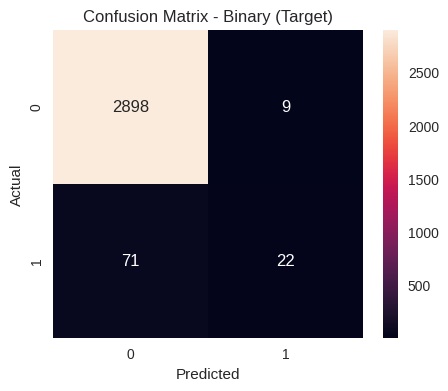


Binary Classification Report:

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2907
           1       0.71      0.24      0.35        93

    accuracy                           0.97      3000
   macro avg       0.84      0.62      0.67      3000
weighted avg       0.97      0.97      0.97      3000



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

cm_bin = confusion_matrix(yb_test, yb_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm_bin, annot=True, fmt="d")
plt.title("Confusion Matrix - Binary (Target)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nBinary Classification Report:\n")
print(classification_report(yb_test, yb_pred))


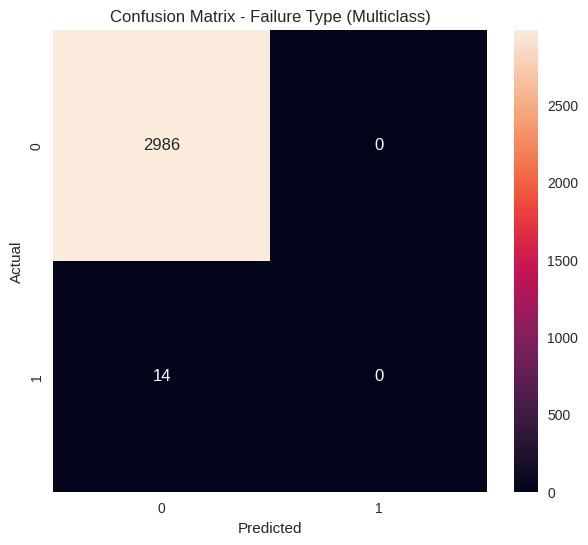


Multiclass Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2986
           1       0.00      0.00      0.00        14

    accuracy                           1.00      3000
   macro avg       0.50      0.50      0.50      3000
weighted avg       0.99      1.00      0.99      3000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
cm_multi = confusion_matrix(yc_test, yc_pred)

plt.figure(figsize=(7,6))
sns.heatmap(cm_multi, annot=True, fmt="d")
plt.title("Confusion Matrix - Failure Type (Multiclass)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\nMulticlass Classification Report:\n")
print(classification_report(yc_test, yc_pred))


In [ ]:
import joblib

joblib.dump(model, 'predictive_maintenance.h5')

['predictive_maintenance.h5']